In [693]:
import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt
import os

focal_length = 910
width = 1164
height = 874
center_x = width/2
center_y = height/2
pp = (center_x, center_y)

K = np.array([[focal_length, 0, center_x],
              [0, focal_length, center_y],
              [0, 0, 1]])


def read_specific_frame(video_directory, frame_number):
    # Construct the path to the specific frame
    frame_path = os.path.join("/Users/ritamsaha/Desktop/whereabouts/calib_challenge/result_labels",video_directory, f"{frame_number}.jpg")

    # Check if the frame exists
    if not os.path.exists(frame_path):
        print(f"Frame {frame_number} does not exist in the directory.")
        return None

    # Read the frame
    frame = cv.imread(frame_path, cv.IMREAD_GRAYSCALE)

    return frame

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

sift = cv.SIFT_create()

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)

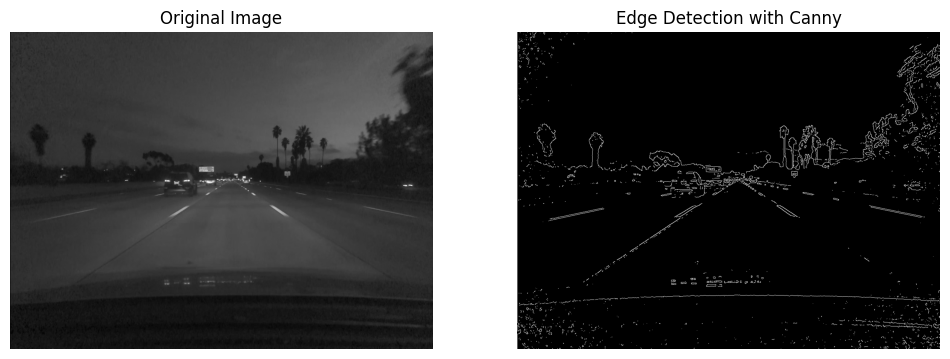

In [747]:
gray_image = read_specific_frame("0",500)
#gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv.Canny(gray_image, 7000, 7000,apertureSize = 7)  # These thresholds can be adjusted

# Display the original and edge-detected images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(gray_image, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color representation
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection with Canny')
plt.axis('off')

plt.show()

In [694]:
import numpy.linalg as la
def getEpipole(frameNumber):
    img1 = read_specific_frame("0",frameNumber)
    img2 = read_specific_frame("0",frameNumber+1)
        # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    matches = flann.knnMatch(des1,des2,k=2)
    pts1 = []
    pts2 = []
        # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

    # SVD of the fundamental matrix
    U, S, Vt = la.svd(F)

    # The epipoles are in the null space of F and F.T respectively
    # For the first image (epipole e1)
    e1 = Vt[-1]
    e1 = e1/e1[-1]  # Dehomogenize (make the last coordinate 1)

    return e1

[4.81399295e+15 3.94761177e+02 1.00000000e+00]


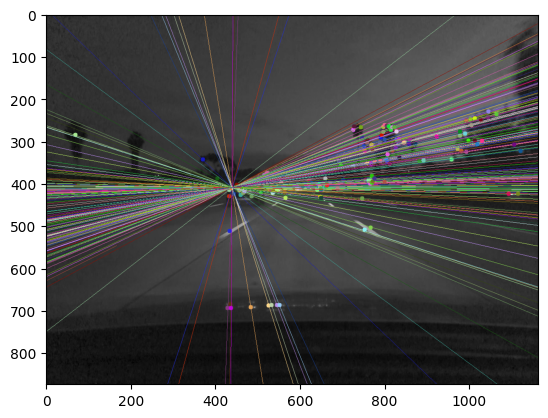

In [700]:
frameNumber = 2

img1 = read_specific_frame("0",frameNumber)
img2 = read_specific_frame("0",frameNumber+1)
    # find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
    # ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
E, mask = cv.findEssentialMat(pts1, pts2, K)
    # We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

_, R, t, mask = cv.recoverPose(E, pts1, pts2, focal=focal_length, pp=pp)

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
print(getEpipole(frameNumber))
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.imshow(img5)
#plt.subplot(121),plt.imshow(img5)
#plt.subplot(122),plt.imshow(img3)
plt.show()

In [644]:
arr1 = getAngle(0)
print("Pitch (Y-axis rotation):", '{:.2e}'.format(arr1[0]), "radians")
print("Yaw (Z-axis rotation):", '{:.2e}'.format(arr1[1]), "radians")
print("Roll (X-axis rotation):", '{:.2e}'.format(arr1[2]), "radians")

Pitch (Y-axis rotation): -1.47e-04 radians
Yaw (Z-axis rotation): -1.09e-03 radians
Roll (X-axis rotation): -1.86e-04 radians


In [668]:
def remove_outliers(data_list):
    for i in range(1, len(data_list)):
        for key in ['x', 'y']:
            if abs(data_list[i][key] - data_list[i - 1][key]) > 500:
                # Option 1: Replace with the previous value
                data_list[i][key] = data_list[i - 1][key]
                
                # Option 2: Remove this point (optional, uncomment if needed)
                # data_list.pop(i)
                # i -= 1
    return data_list

def moving_average(data_list, window_size):
    smoothed_data = []
    for i in range(len(data_list)):
        start_index = max(i - window_size // 2, 0)
        end_index = min(i + window_size // 2 + 1, len(data_list))
        window = data_list[start_index:end_index]
        avg_x = sum(d['x'] for d in window) / len(window)
        avg_y = sum(d['y'] for d in window) / len(window)
        smoothed_data.append({'Frame': data_list[i]['Frame'], 'x': avg_x, 'y': avg_y})
    return smoothed_data

694.23306318998
630.1618634717271
439.0020378979885
686.3611003155042
756.4578485835091
632.1023461996303
697.3498130243282
472.780976375982
739.8767933626974
600.8441692426305


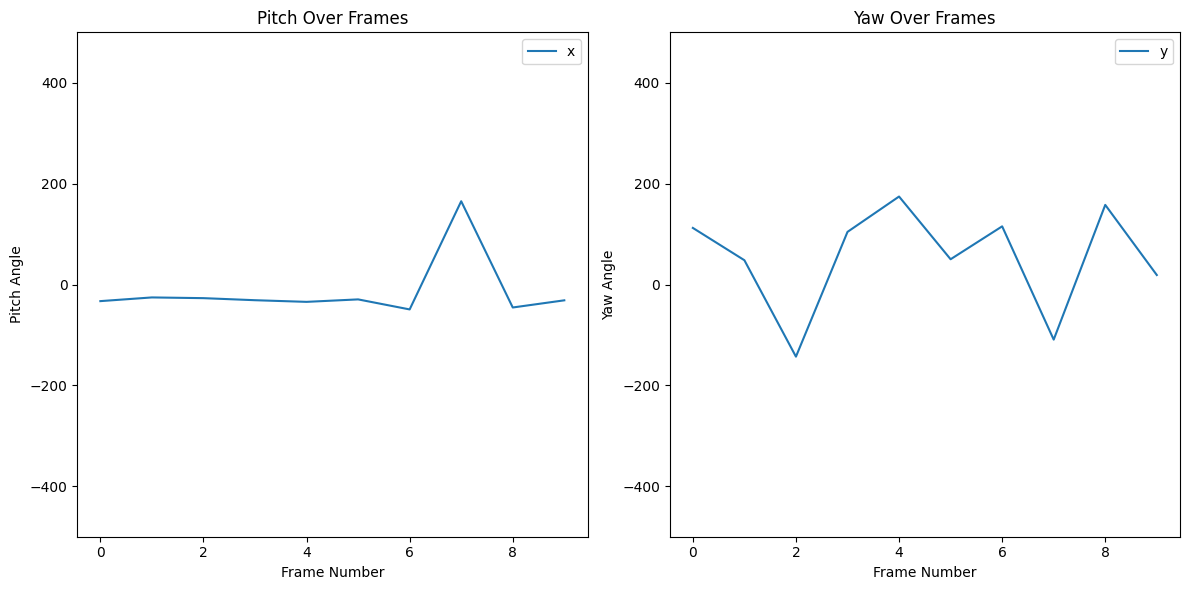

In [679]:
data_list = []

for frame_number in range(0, 10):
    x, y, _ = getEpipole(frame_number)
    print(x)
    data_list.append({'Frame': frame_number, 'x': x, 'y': y})

data_list = remove_outliers(data_list)

for data in data_list:
    data['x'] -= center_x
    data['y'] -= center_y

data = pd.DataFrame(data_list)

plt.figure(figsize=(12, 6))

# Plot Pitch
plt.subplot(1, 2, 1)
plt.plot(data['Frame'], data['y'], label='x')
plt.xlabel('Frame Number')
plt.ylabel('Pitch Angle')
plt.title('Pitch Over Frames')
plt.legend()
plt.ylim([-500, 500])  # Set y-axis range for pitch


# Plot Yaw
plt.subplot(1, 2, 2)
plt.plot(data['Frame'], data['x'], label='y')
plt.xlabel('Frame Number')
plt.ylabel('Yaw Angle')
plt.title('Yaw Over Frames')
plt.legend()
plt.ylim([-500, 500]) 

plt.tight_layout()
plt.show()

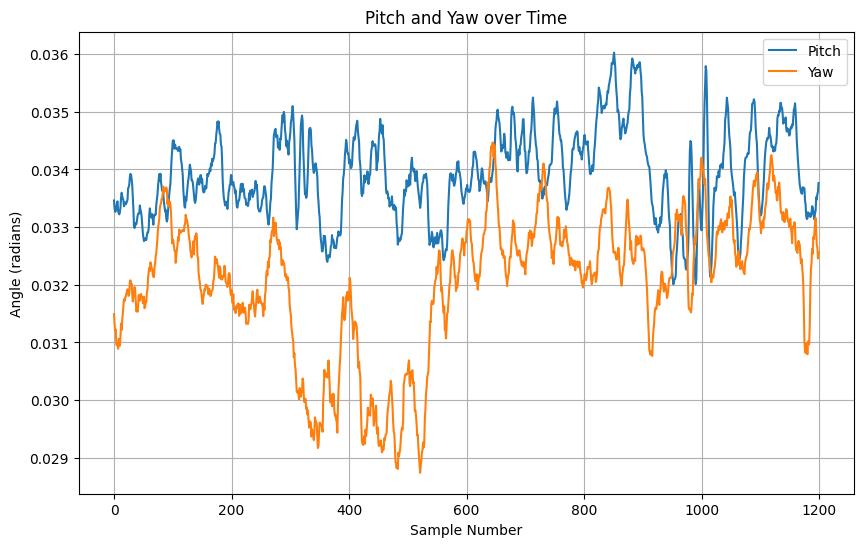

In [646]:
data = pd.read_csv('/Users/ritamsaha/Desktop/whereabouts/calib_challenge/labeled/0.txt', sep=' ', header=None, names=['pitch', 'yaw'])

# Plotting
plt.figure(figsize=(10,6))
plt.plot(data['pitch'], label='Pitch')
plt.plot(data['yaw'], label='Yaw')
plt.xlabel('Sample Number')
plt.ylabel('Angle (radians)')
plt.title('Pitch and Yaw over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def getAngle(frameNumber):
    img1 = read_specific_frame("0",frameNumber)
    img2 = read_specific_frame("0",frameNumber+1)
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    matches = flann.knnMatch(des1,des2,k=2)
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    E, mask = cv.findEssentialMat(pts1, pts2, K)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]

    _, R, t, mask = cv.recoverPose(E, pts1, pts2, focal=focal_length, pp=pp)

    arr1 = rotationMatrixToEulerAngles(R)
    return arr1